In [115]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [116]:
using_colab = False

In [117]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p videos
    !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    !unzip -d videos videos/bedroom.zip

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Set-up

In [118]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [119]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Trimming the video

In [ ]:
# ============= STEP 1: FIND FIRST ANNOTATED FRAME AND PREPROCESS =============

import json
import cv2
import os
import shutil
from datetime import datetime

print(f"\n{'='*70}")
print(f"STEP 1: PREPROCESSING - Find annotated frame and trim video")
print(f"{'='*70}")

# Load JSON to find first annotated frame
print(f"\n📄 Loading annotations from: {os.path.basename(ANNOTATION_FILE)}")

with open(ANNOTATION_FILE, 'r') as f:
    data = json.load(f)

# Find first frame with bounding boxes
first_annotated_frame_no = None
num_boxes = 0

for frame_data in data["frames"]:
    boxes = frame_data.get("annotation", {}).get("boxes", [])
    if len(boxes) > 0:
        first_annotated_frame_no = frame_data["frameNo"]
        num_boxes = len(boxes)
        print(f"✓ Found first annotated frame: frameNo {first_annotated_frame_no}")
        print(f"  Number of objects: {num_boxes}")
        break

if first_annotated_frame_no is None:
    raise ValueError("No annotated frames found in JSON!")

# Load video properties
cap = cv2.VideoCapture(VIDEO_PATH)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"\n📹 Original video properties:")
print(f"  Total frames: {total_frames}")
print(f"  FPS: {fps}")
print(f"  Resolution: {width}x{height}")

# Calculate trim range (frameNo is 1-indexed, video frames are 0-indexed)
trim_start_frame = first_annotated_frame_no - 1  # Convert to 0-indexed
trim_end_frame = total_frames - 1
frames_to_extract = trim_end_frame - trim_start_frame + 1

print(f"\n✂️  Trimming video:")
print(f"  Start from frame: {trim_start_frame} (0-indexed) / frameNo {first_annotated_frame_no} (JSON)")
print(f"  End at frame: {trim_end_frame}")
print(f"  Frames to extract: {frames_to_extract}")

# Create processed folder
processed_dir = os.path.join(INPUT_FOLDER, "processed")
os.makedirs(processed_dir, exist_ok=True)
print(f"\n📁 Created processed folder: {processed_dir}")

# ============= TRIM VIDEO =============
print(f"\n⏳ Trimming video from frame {trim_start_frame}...")

video_name_base = os.path.splitext(os.path.basename(VIDEO_PATH))[0]
trimmed_video_path = os.path.join(processed_dir, f"{video_name_base}_processed.mp4")

# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_writer = cv2.VideoWriter(trimmed_video_path, fourcc, fps, (width, height))

# Read and write frames from trim_start_frame onwards
cap.set(cv2.CAP_PROP_POS_FRAMES, trim_start_frame)
frames_written = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    out_writer.write(frame)
    frames_written += 1
    
    if frames_written % 50 == 0:
        print(f"  Progress: {frames_written}/{frames_to_extract} frames", end='\r')

cap.release()
out_writer.release()

print(f"\n✓ Trimmed video saved: {frames_written} frames")
print(f"  {os.path.basename(trimmed_video_path)}")

# ============= CREATE PROCESSED JSON (RENUMBER FRAMES) =============
print(f"\n📝 Creating processed JSON with renumbered frames...")

processed_frames = []
frame_offset = first_annotated_frame_no - 1  # How many frames we skipped

for frame_data in data["frames"]:
    original_frame_no = frame_data["frameNo"]
    
    # Only include frames from first_annotated_frame_no onwards
    if original_frame_no >= first_annotated_frame_no:
        # Renumber: frameNo 8 becomes 1, frameNo 9 becomes 2, etc.
        new_frame_no = original_frame_no - frame_offset
        
        new_frame_data = frame_data.copy()
        new_frame_data["frameNo"] = new_frame_no
        new_frame_data["originalFrameNo"] = original_frame_no  # Keep original for reference
        
        processed_frames.append(new_frame_data)

# Create processed JSON data
processed_json = {
    "taskId": data.get("taskId", ""),
    "campaignId": data.get("campaignId", ""),
    "videoName": f"{video_name_base}_processed",
    "metadata": {
        "fps": fps,
        "totalFrames": frames_written,
        "segmentStart": 1,
        "segmentEnd": frames_written,
        "originalFirstFrame": first_annotated_frame_no,
        "frameOffset": frame_offset,
        "processedDate": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "sourceVideo": os.path.basename(VIDEO_PATH),
        "sourceJSON": os.path.basename(ANNOTATION_FILE)
    },
    "frames": processed_frames
}

# Save processed JSON
processed_json_path = os.path.join(processed_dir, f"{video_name_base}_processed.json")
with open(processed_json_path, 'w') as f:
    json.dump(processed_json, f, indent=2)

print(f"✓ Processed JSON saved: {len(processed_frames)} frames")
print(f"  {os.path.basename(processed_json_path)}")

# Count annotated frames
num_annotated = sum(1 for f in processed_frames if len(f.get("annotation", {}).get("boxes", [])) > 0)
print(f"  Frames with annotations: {num_annotated}/{len(processed_frames)}")

# ============= CREATE ANNOTATIONS.TXT SUMMARY =============
annotations_txt_path = os.path.join(processed_dir, "annotations.txt")

with open(annotations_txt_path, 'w') as f:
    f.write(f"PROCESSED VIDEO ANNOTATIONS\n")
    f.write(f"{'='*70}\n\n")
    f.write(f"Source Video: {os.path.basename(VIDEO_PATH)}\n")
    f.write(f"Source JSON: {os.path.basename(ANNOTATION_FILE)}\n")
    f.write(f"Processed Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write(f"Video Properties:\n")
    f.write(f"  Resolution: {width}x{height}\n")
    f.write(f"  FPS: {fps}\n")
    f.write(f"  Total Frames: {frames_written}\n\n")
    f.write(f"Processing:\n")
    f.write(f"  Original first annotated frame: frameNo {first_annotated_frame_no} (JSON)\n")
    f.write(f"  Now starts at: frameNo 1 (processed JSON)\n")
    f.write(f"  Frame offset: {frame_offset} frames removed\n\n")
    f.write(f"Annotations:\n")
    f.write(f"  Total annotated frames: {num_annotated}\n")
    f.write(f"  Objects in first frame: {num_boxes}\n\n")
    
    # List all annotated frames
    f.write(f"Annotated Frame List:\n")
    for frame_data in processed_frames:
        boxes = frame_data.get("annotation", {}).get("boxes", [])
        if len(boxes) > 0:
            original_no = frame_data.get("originalFrameNo", "N/A")
            new_no = frame_data["frameNo"]
            f.write(f"  frameNo {new_no} (was {original_no}): {len(boxes)} objects\n")
            for box in boxes:
                label = box.get("label", "unknown")
                box_type = box.get("boxType", "unknown")
                f.write(f"    - {box_type} (label: {label})\n")

print(f"✓ Annotations summary saved:")
print(f"  {os.path.basename(annotations_txt_path)}")

# ============= UPDATE PATHS FOR REST OF PIPELINE =============
# Update VIDEO_PATH and ANNOTATION_FILE to use processed versions
VIDEO_PATH = trimmed_video_path
ANNOTATION_FILE = processed_json_path

print(f"\n{'='*70}")
print(f"✅ PREPROCESSING COMPLETE")
print(f"{'='*70}")
print(f"\nProcessed files:")
print(f"  📹 Video: {os.path.basename(trimmed_video_path)} ({frames_written} frames)")
print(f"  📄 JSON: {os.path.basename(processed_json_path)} ({len(processed_frames)} frames)")
print(f"  📝 TXT: {os.path.basename(annotations_txt_path)}")
print(f"\n💡 First annotated frame is NOW frame 0 (frameNo 1 in JSON)")
print(f"{'='*70}\n")

In [ ]:
# ============= STEP 2: EXTRACT FRAMES FROM PROCESSED VIDEO =============

import cv2, os

print(f"\n{'='*70}")
print(f"STEP 2: EXTRACTING FRAMES")
print(f"{'='*70}")

# Extract video name without extension
video_name = os.path.splitext(os.path.basename(VIDEO_PATH))[0]
video_dir_base = os.path.dirname(VIDEO_PATH)

# Create directory structure: processed/videoname/frames
frames_dir = os.path.join(video_dir_base, video_name, "frames")
os.makedirs(frames_dir, exist_ok=True)

cap = cv2.VideoCapture(VIDEO_PATH)
original_fps = cap.get(cv2.CAP_PROP_FPS)
target_fps = 20

# Calculate frame interval to achieve target FPS
frame_interval = int(original_fps / target_fps) if original_fps > target_fps else 1

idx = 0
frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Only save frames at the target FPS rate
    if idx % frame_interval == 0:
        cv2.imwrite(f"{frames_dir}/{frame_count:05d}.jpg", frame)
        frame_count += 1
    
    idx += 1

cap.release()

print(f"\nOriginal FPS: {original_fps}")
print(f"Target FPS: {target_fps}")
print(f"Total frames extracted: {frame_count}")
print(f"Frames saved to: {frames_dir}")
print(f"{'='*70}\n")

In [ ]:
# ============= STEP 3: LOAD FRAMES AND VERIFY =============

print(f"\n{'='*70}")
print(f"STEP 3: LOADING FRAMES")
print(f"{'='*70}")

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(frames_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

print(f"\nTotal frames loaded: {len(frame_names)}")

# Load JSON to get first annotated frame (should be frameNo 1 now)
with open(ANNOTATION_FILE, 'r') as f:
    data = json.load(f)

# Find first annotated frame in processed JSON
START_FRAME = None
for frame_data in data["frames"]:
    boxes = frame_data.get("annotation", {}).get("boxes", [])
    if len(boxes) > 0:
        # frameNo in processed JSON is 1-indexed, convert to 0-indexed for frame array
        START_FRAME = frame_data["frameNo"] - 1
        num_boxes = len(boxes)
        print(f"✓ First annotated frame: frame_idx {START_FRAME} (frameNo {frame_data['frameNo']} in JSON)")
        print(f"  Number of objects: {num_boxes}")
        break

if START_FRAME is None:
    raise ValueError("No annotated frames found!")

# Display the first annotated frame
plt.figure(figsize=(12, 8))
plt.title(f"First Annotated Frame (frame {START_FRAME}, frameNo {START_FRAME + 1})")
plt.imshow(Image.open(os.path.join(frames_dir, frame_names[START_FRAME])))
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n✓ Frame {START_FRAME} will be used for SAM2 initialization")
print(f"{'='*70}\n")

### Loading the SAM 2 video predictor

In [120]:
from sam2.build_sam import build_sam2_video_predictor
sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"

model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [121]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

In [122]:
# ============= CONFIGURATION =============

# Input: Video data folder containing video file and annotation JSON
INPUT_FOLDER = "/home/multi-gpu/ai_res/Hira/sam2-visionrd/DATA/exp"

print(f"Input folder: {INPUT_FOLDER}")

# Auto-detect video and annotation files in the folder
import glob

# Find JSON annotation file
json_files = glob.glob(os.path.join(INPUT_FOLDER, "*.json"))
if len(json_files) == 0:
    raise ValueError(f"No JSON annotation file found in {INPUT_FOLDER}")
elif len(json_files) > 1:
    print(f"⚠ Multiple JSON files found: {json_files}")
    print(f"  Using first one: {json_files[0]}")

ANNOTATION_FILE = json_files[0]
print(f"✓ Found annotation: {os.path.basename(ANNOTATION_FILE)}")

# Find ANY video file in the folder (simpler approach)
video_extensions = ['*.mp4', '*.avi', '*.mov', '*.mkv']
video_files = []

for ext in video_extensions:
    video_files.extend(glob.glob(os.path.join(INPUT_FOLDER, ext)))

if len(video_files) == 0:
    raise ValueError(f"No video file found in {INPUT_FOLDER}\nSearched for extensions: .mp4, .avi, .mov, .mkv")
elif len(video_files) > 1:
    print(f"⚠ Multiple video files found: {[os.path.basename(f) for f in video_files]}")
    print(f"  Using first one: {os.path.basename(video_files[0])}")

VIDEO_PATH = video_files[0]
print(f"✓ Found video: {os.path.basename(VIDEO_PATH)}")

# Model configuration - Choose one:
# Option 1: Tiny 512 (LOWEST MEMORY - Recommended for 2000+ frames)

CHECKPOINT = "../checkpoints/sam2.1_hiera_tiny.pt"

MODEL_CFG = "configs/sam2.1/sam2.1_hiera_t.yaml"

# Option 2: Tiny 1024 (Low memory, better quality)
# MODEL_CFG = "configs/sam2.1/sam2.1_hiera_t.yaml"
# CHECKPOINT = "checkpoints/sam2.1_hiera_tiny.pt"

# Option 3: Small (More memory, best quality)
# MODEL_CFG = "configs/sam2.1/sam2.1_hiera_s.yaml"
# CHECKPOINT = "checkpoints/sam2.1_hiera_small.pt"

# Output configuration - mirror input folder structure
folder_name = os.path.basename(INPUT_FOLDER.rstrip('/'))
OUTPUT_DIR = folder_name  # Save directly to folder with same name as input
SAVE_MASKS = True  # Save individual masks per frame
SAVE_RAW_VIDEO = True  # Copy original video to raw/ subfolder
SAVE_MASKS_ONLY_VIDEO = True  # Save binary masks video (black background)
SAVE_OVERLAY_VIDEO = True  # Save video with mask overlays
VISUALIZATION_INTERVAL = 100  # Show preview every N frames

# Performance optimization
VOS_OPTIMIZED = True  # Enable model compilation (faster after warmup)

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"\n✓ Configuration set")
print(f"  Model: {MODEL_CFG }")
print(f"  Output folder: {OUTPUT_DIR}")


Input folder: /home/multi-gpu/ai_res/Hira/sam2-visionrd/DATA/exp
✓ Found annotation: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_annotations.json
✓ Found video: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed.mp4

✓ Configuration set
  Model: configs/sam2.1/sam2.1_hiera_t.yaml
  Output folder: exp


In [123]:
import cv2, os

# Extract video name without extension
video_name = os.path.splitext(os.path.basename(VIDEO_PATH))[0]
video_dir_base = os.path.dirname(VIDEO_PATH)

# Create directory structure: video_dir_path/videoname/frames
frames_dir = os.path.join(video_dir_base, video_name, "frames")
os.makedirs(frames_dir, exist_ok=True)

cap = cv2.VideoCapture(VIDEO_PATH)
original_fps = cap.get(cv2.CAP_PROP_FPS)
target_fps = 20

# Calculate frame interval to achieve target FPS
frame_interval = int(original_fps / target_fps) if original_fps > target_fps else 1

idx = 0
frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Only save frames at the target FPS rate
    if idx % frame_interval == 0:
        cv2.imwrite(f"{frames_dir}/{frame_count:05d}.jpg", frame)
        frame_count += 1
    
    idx += 1

cap.release()

print(f"Original FPS: {original_fps}")
print(f"Target FPS: {target_fps}")
print(f"Total frames extracted: {frame_count}")
print(f"Frames saved to: {frames_dir}")

Original FPS: 20.0
Target FPS: 20
Total frames extracted: 16
Frames saved to: /home/multi-gpu/ai_res/Hira/sam2-visionrd/DATA/exp/24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed/frames



STEP 1: PREPROCESSING - Find annotated frame and trim video

📄 Loading annotations from: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_annotations.json
✓ Found first annotated frame: frameNo 8
  Number of objects: 5

📹 Original video properties:
  Total frames: 16
  FPS: 20.0
  Resolution: 640x480

✂️  Trimming video:
  Start from frame: 7 (0-indexed) / frameNo 8 (JSON)
  End at frame: 15
  Frames to extract: 9

📁 Created processed folder: /home/multi-gpu/ai_res/Hira/sam2-visionrd/DATA/exp/processed

⏳ Trimming video from frame 7...

✓ Trimmed video saved: 9 frames
  24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed.mp4

📝 Creating processed JSON with renumbered frames...
✓ Processed JSON saved: 9 frames
  24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed.json
  Frames with annotations: 1/9
✓ Annotations summary saved:
  annotations.txt

✅ PREPROCESSING COMPLETE

Processed files:
  📹 Video: 24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed.mp4 (9 


STEP 2: EXTRACTING FRAMES

Original FPS: 20.0
Target FPS: 20
Total frames extracted: 9
Frames saved to: /home/multi-gpu/ai_res/Hira/sam2-visionrd/DATA/exp/processed/24-DEC-25-10:42:11:AM_2.avi (trim 1)_trimmed_trimmed_processed/frames




STEP 3: LOADING FRAMES

Total frames loaded: 9
✓ First annotated frame: frame_idx 0 (frameNo 1 in JSON)
  Number of objects: 5


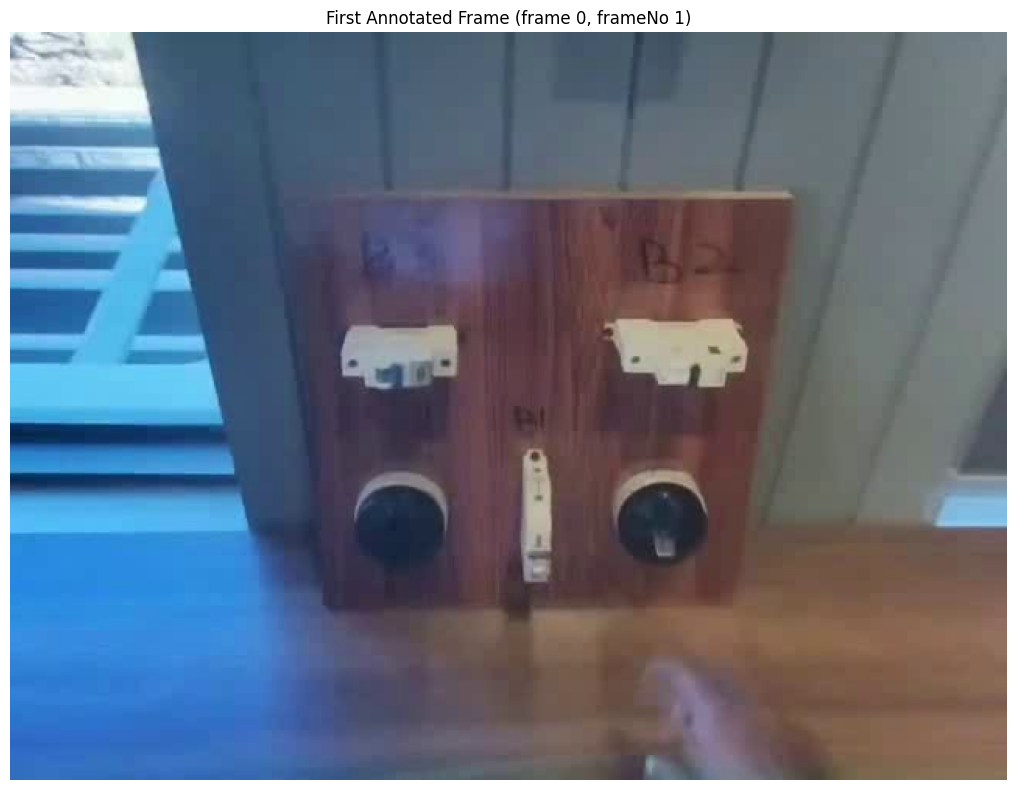


✓ Frame 0 will be used for SAM2 initialization



#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [99]:
inference_state = predictor.init_state(video_path=frames_dir)

frame loading (JPEG): 100%|██████████| 9/9 [00:00<00:00, 50.33it/s]


### Example 1: Segment & track one object

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [70]:
predictor.reset_state(inference_state)


🎯 Initializing SAM2 predictions from 5 annotated boxes...
  Object 1 (label=9): box=[373, 177, 477, 232]
  Object 2 (label=10): box=[202, 180, 296, 235]
  Object 3 (label=8): box=[319, 262, 353, 359]
  Object 4 (label=7): box=[382, 275, 450, 345]
  Object 5 (label=6): box=[215, 277, 284, 349]

✓ Initialized 5 object masks


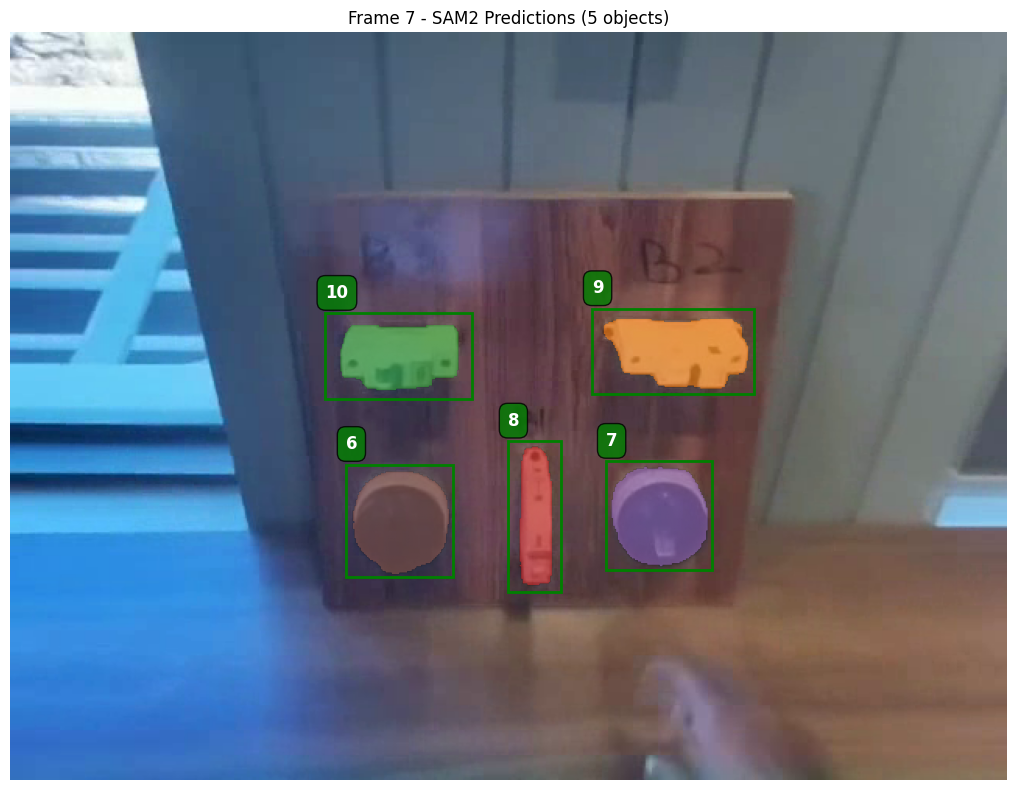


✓ Initial segmentation complete!
  Next: Run propagate_in_video to track objects across all frames


In [75]:
# ============= INITIALIZE SAM2 WITH BOUNDING BOXES =============

print(f"\n🎯 Initializing SAM2 predictions from {num_boxes} annotated boxes...")

# Extract boxes from the annotated frame
annotated_boxes = []
for frame_data in data["frames"]:
    if frame_data["frameNo"] - 1 == START_FRAME:
        annotated_boxes = frame_data["annotation"]["boxes"]
        break

# Process each bounding box
all_masks = {}
for idx, box_data in enumerate(annotated_boxes):
    # Extract normalized coordinates from 4 points
    coords = box_data["coordinates"]
    
    # Get all x and y coordinates
    x_coords = [coords[f"point{i}"]["x"] for i in range(1, 5)]
    y_coords = [coords[f"point{i}"]["y"] for i in range(1, 5)]
    
    # Get bounding box (normalized 0-1)
    x_min_norm = min(x_coords)
    x_max_norm = max(x_coords)
    y_min_norm = min(y_coords)
    y_max_norm = max(y_coords)
    
    # Convert to pixel coordinates
    x_min = int(x_min_norm * width)
    y_min = int(y_min_norm * height)
    x_max = int(x_max_norm * width)
    y_max = int(y_max_norm * height)
    
    # Convert to SAM2 format (x_min, y_min, x_max, y_max)
    box = np.array([x_min, y_min, x_max, y_max], dtype=np.float32)
    
    # Use sequential numbering for obj_id (MUST be integer for SAM2)
    obj_id = idx + 1
    # Get label from JSON for display
    label = str(box_data.get("label", f"object_{obj_id}"))
    
    print(f"  Object {obj_id} (label={label}): box=[{x_min}, {y_min}, {x_max}, {y_max}]")
    
    # Add box to SAM2 predictor
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=START_FRAME,
        obj_id=obj_id,
        box=box,
    )
    
    # FIXED: Find the correct mask index for this obj_id
    # out_obj_ids contains the IDs returned, find where our obj_id is
    mask_idx = list(out_obj_ids).index(obj_id)
    
    # Store the CORRECT mask for this object
    all_masks[obj_id] = {
        'mask_logits': out_mask_logits[mask_idx],
        'mask': (out_mask_logits[mask_idx] > 0.0).cpu().numpy(),
        'box': box,
        'label': label
    }

print(f"\n✓ Initialized {len(all_masks)} object masks")

# ============= VISUALIZE PREDICTIONS =============
plt.figure(figsize=(12, 8))
plt.imshow(first_frame_rgb)
plt.title(f"Frame {START_FRAME} - SAM2 Predictions ({len(all_masks)} objects)")

# Show each mask and box
for obj_id, mask_info in all_masks.items():
    # Draw mask
    show_mask(mask_info['mask'], plt.gca(), obj_id=obj_id)
    
    # Draw box
    show_box(mask_info['box'], plt.gca())
    
    # Add label
    box = mask_info['box']
    plt.text(box[0], box[1]-10, mask_info['label'], 
             color='white', fontsize=12, weight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='green', alpha=0.8))

plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n✓ Initial segmentation complete!")
print(f"  Next: Run propagate_in_video to track objects across all frames")

In [38]:
# ============= SAVE VIDEOS =============

import cv2
import numpy as np

# Create output directory for videos (use absolute path)
video_output_dir = os.path.abspath(os.path.join(OUTPUT_DIR, "videos"))
os.makedirs(video_output_dir, exist_ok=True)

# Output video paths
video_name_base = os.path.splitext(os.path.basename(VIDEO_PATH))[0]
original_video_path = os.path.join(video_output_dir, f"{video_name_base}_original_from_frame{START_FRAME}.mp4")
overlay_video_path = os.path.join(video_output_dir, f"{video_name_base}_sam2_overlay_from_frame{START_FRAME}.mp4")

# Video settings
output_fps = 20  # Match the extracted frames FPS

# Read first frame to get dimensions
first_img = cv2.imread(os.path.join(frames_dir, frame_names[START_FRAME]))
if first_img is None:
    raise ValueError(f"Cannot read first frame: {frame_names[START_FRAME]}")
height, width = first_img.shape[:2]

print(f"\n🎥 Creating videos from frame {START_FRAME} onwards...")
print(f"  Output directory: {video_output_dir}")
print(f"  Resolution: {width}x{height}")
print(f"  Output FPS: {output_fps}")
print(f"  Total frames to write: {len(frame_names) - START_FRAME}")

# Try different codecs in order of preference
codecs_to_try = [
    ('mp4v', 'mp4v'),
    ('avc1', 'H264'),
    ('H264', 'H264'),
    ('X264', 'X264'),
]

original_writer = None
overlay_writer = None

for codec_name, codec_desc in codecs_to_try:
    fourcc = cv2.VideoWriter_fourcc(*codec_name)
    
    # Try to initialize writers
    temp_original = cv2.VideoWriter(original_video_path, fourcc, output_fps, (width, height))
    temp_overlay = cv2.VideoWriter(overlay_video_path, fourcc, output_fps, (width, height))
    
    # Check if both opened successfully
    if temp_original.isOpened() and temp_overlay.isOpened():
        original_writer = temp_original
        overlay_writer = temp_overlay
        print(f"✓ Using codec: {codec_desc} ({codec_name})")
        break
    else:
        temp_original.release()
        temp_overlay.release()

if original_writer is None or overlay_writer is None:
    raise RuntimeError("Failed to initialize video writers with any codec. Try installing ffmpeg or using a different output format.")

print(f"\n⏳ Writing videos...")

# Process frames from START_FRAME onwards
frames_written = 0
for frame_idx in range(START_FRAME, len(frame_names)):
    # Read original frame
    frame_path = os.path.join(frames_dir, frame_names[frame_idx])
    frame = cv2.imread(frame_path)
    
    if frame is None:
        print(f"\n⚠ Warning: Could not read frame {frame_idx}, skipping...")
        continue
    
    # Write original frame
    original_writer.write(frame)
    
    # Create overlay frame
    overlay_frame = frame.copy()
    
    # Draw masks on overlay frame if this frame was segmented
    if frame_idx in video_segments:
        # Convert to RGB for mask overlay
        overlay_rgb = cv2.cvtColor(overlay_frame, cv2.COLOR_BGR2RGB)
        
        # Draw each mask
        for obj_id, mask in video_segments[frame_idx].items():
            # Get color for this object
            cmap = plt.get_cmap("tab10")
            color = np.array([*cmap(obj_id)[:3], 0.6])
            
            # Apply mask overlay - ensure mask is 2D
            mask_2d = mask.squeeze()
            mask_3channel = np.repeat(mask_2d[:, :, np.newaxis], 3, axis=2)
            color_rgb = color[:3].reshape(1, 1, 3)
            mask_colored = (mask_3channel * color_rgb * 255).astype(np.uint8)
            
            # Blend with original
            overlay_rgb = cv2.addWeighted(overlay_rgb, 1.0, mask_colored, 0.6, 0)
            
            # Draw bounding box
            mask_info = all_masks.get(obj_id, {})
            if 'box' in mask_info:
                box = mask_info['box']
                x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
                cv2.rectangle(overlay_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                # Add label
                label = mask_info.get('label', f'obj_{obj_id}')
                cv2.putText(overlay_rgb, label, (x1, y1-5), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        # Convert back to BGR
        overlay_frame = cv2.cvtColor(overlay_rgb, cv2.COLOR_RGB2BGR)
    
    # Write overlay frame
    overlay_writer.write(overlay_frame)
    frames_written += 1
    
    # Progress indicator
    if frames_written % 10 == 0:
        progress = frames_written / (len(frame_names) - START_FRAME) * 100
        print(f"  Progress: {progress:.1f}% ({frames_written}/{len(frame_names) - START_FRAME} frames)", end='\r')

# Release writers
original_writer.release()
overlay_writer.release()

# Verify files were created
original_exists = os.path.exists(original_video_path)
overlay_exists = os.path.exists(overlay_video_path)
original_size = os.path.getsize(original_video_path) if original_exists else 0
overlay_size = os.path.getsize(overlay_video_path) if overlay_exists else 0

print(f"\n\n{'='*70}")
if original_exists and overlay_exists and original_size > 0 and overlay_size > 0:
    print(f"✅ VIDEOS SAVED SUCCESSFULLY")
else:
    print(f"⚠️  WARNING: VIDEO FILES MAY NOT BE PROPERLY SAVED")
print(f"{'='*70}")
print(f"📁 Output directory: {video_output_dir}")
print(f"\n📹 Original Video:")
print(f"   {original_video_path}")
print(f"   - Status: {'✓ Saved' if original_exists else '✗ NOT FOUND'} ({original_size/1024/1024:.2f} MB)")
print(f"   - Frames: {START_FRAME} to {len(frame_names)-1} ({frames_written} frames written)")
print(f"   - Resolution: {width}x{height}")
print(f"   - FPS: {output_fps}")
print(f"\n🎨 SAM2 Overlay Video:")
print(f"   {overlay_video_path}")
print(f"   - Status: {'✓ Saved' if overlay_exists else '✗ NOT FOUND'} ({overlay_size/1024/1024:.2f} MB)")
print(f"   - Frames: {START_FRAME} to {len(frame_names)-1} ({frames_written} frames written)")
print(f"   - Objects tracked: {len(all_masks)}")
print(f"   - Resolution: {width}x{height}")
print(f"   - FPS: {output_fps}")
print(f"{'='*70}")

# Try to display paths for easy access
print(f"\n💡 To view videos, run:")
print(f"   ls -lh {video_output_dir}")


🎥 Creating videos from frame 0 onwards...
  Output directory: /home/multi-gpu/ai_res/Hira/sam2-visionrd/notebooks/task_854715-hd_1920_1080_30fps_20260206_162416_export/videos
  Resolution: 1920x1080
  Output FPS: 20
  Total frames to write: 245
✓ Using codec: mp4v (mp4v)

⏳ Writing videos...
  Progress: 98.0% (240/245 frames)

✅ VIDEOS SAVED SUCCESSFULLY
📁 Output directory: /home/multi-gpu/ai_res/Hira/sam2-visionrd/notebooks/task_854715-hd_1920_1080_30fps_20260206_162416_export/videos

📹 Original Video:
   /home/multi-gpu/ai_res/Hira/sam2-visionrd/notebooks/task_854715-hd_1920_1080_30fps_20260206_162416_export/videos/854715-hd_1920_1080_30fps_original_from_frame0.mp4
   - Status: ✓ Saved (7.89 MB)
   - Frames: 0 to 244 (245 frames written)
   - Resolution: 1920x1080
   - FPS: 20

🎨 SAM2 Overlay Video:
   /home/multi-gpu/ai_res/Hira/sam2-visionrd/notebooks/task_854715-hd_1920_1080_30fps_20260206_162416_export/videos/854715-hd_1920_1080_30fps_sam2_overlay_from_frame0.mp4
   - Status: ✓ 

In [41]:
# ============= SAVE VIDEOS =============

import cv2
import numpy as np

# Create output directory (use absolute path)
video_output_dir = os.path.abspath("outputs")
os.makedirs(video_output_dir, exist_ok=True)

# Video settings
output_fps = 20  # Match the extracted frames FPS

# Read first frame to get dimensions
first_img = cv2.imread(os.path.join(frames_dir, frame_names[START_FRAME]))
if first_img is None:
    raise ValueError(f"Cannot read first frame: {frame_names[START_FRAME]}")
height, width = first_img.shape[:2]

video_name_base = os.path.splitext(os.path.basename(VIDEO_PATH))[0]

print(f"\n🎥 Creating videos from frame {START_FRAME} onwards...")
print(f"  Output directory: {video_output_dir}")
print(f"  Resolution: {width}x{height}")
print(f"  Output FPS: {output_fps}")
print(f"  Total frames to write: {len(frame_names) - START_FRAME}")
print(f"  Objects to save: {len(all_masks)}")

# Try different codecs in order of preference
codecs_to_try = [
    ('mp4v', 'mp4v'),
    ('avc1', 'H264'),
    ('H264', 'H264'),
    ('X264', 'X264'),
]

# Find working codec
working_codec = None
for codec_name, codec_desc in codecs_to_try:
    fourcc = cv2.VideoWriter_fourcc(*codec_name)
    test_path = os.path.join(video_output_dir, "test.mp4")
    test_writer = cv2.VideoWriter(test_path, fourcc, output_fps, (width, height))
    
    if test_writer.isOpened():
        working_codec = fourcc
        test_writer.release()
        if os.path.exists(test_path):
            os.remove(test_path)
        print(f"✓ Using codec: {codec_desc} ({codec_name})")
        break
    else:
        test_writer.release()

if working_codec is None:
    raise RuntimeError("Failed to initialize video writers with any codec. Try installing ffmpeg.")

# Initialize video writers for original and overlay
original_video_path = os.path.join(video_output_dir, f"{video_name_base}_original_from_frame{START_FRAME}.mp4")
overlay_video_path = os.path.join(video_output_dir, f"{video_name_base}_sam2_overlay_from_frame{START_FRAME}.mp4")

original_writer = cv2.VideoWriter(original_video_path, working_codec, output_fps, (width, height))
overlay_writer = cv2.VideoWriter(overlay_video_path, working_codec, output_fps, (width, height))

# Initialize video writers for each object (masked only - ISOLATED ON BLACK)
object_writers = {}
object_video_paths = {}

for obj_id, mask_info in all_masks.items():
    label = mask_info.get('label', f'obj_{obj_id}')
    # Clean label for filename (remove spaces and special chars)
    clean_label = ''.join(c if c.isalnum() or c in ['-', '_'] else '_' for c in label)
    
    obj_video_path = os.path.join(video_output_dir, f"{video_name_base}_object_{obj_id}_{clean_label}_ISOLATED_from_frame{START_FRAME}.mp4")
    obj_writer = cv2.VideoWriter(obj_video_path, working_codec, output_fps, (width, height))
    
    if obj_writer.isOpened():
        object_writers[obj_id] = obj_writer
        object_video_paths[obj_id] = obj_video_path
        print(f"  ✓ Initialized ISOLATED video for {label} (ID: {obj_id})")
    else:
        print(f"  ✗ Failed to initialize writer for {label} (ID: {obj_id})")

print(f"\n⏳ Writing videos...")

# Process frames from START_FRAME onwards
frames_written = 0
for frame_idx in range(START_FRAME, len(frame_names)):
    # Read original frame
    frame_path = os.path.join(frames_dir, frame_names[frame_idx])
    frame = cv2.imread(frame_path)
    
    if frame is None:
        print(f"\n⚠ Warning: Could not read frame {frame_idx}, skipping...")
        continue
    
    # Write original frame
    original_writer.write(frame)
    
    # Create overlay frame
    overlay_frame = frame.copy()
    
    # Process masks if this frame was segmented
    if frame_idx in video_segments:
        # Convert to RGB for mask overlay
        overlay_rgb = cv2.cvtColor(overlay_frame, cv2.COLOR_BGR2RGB)
        
        # Draw each mask on overlay
        for obj_id, mask in video_segments[frame_idx].items():
            # Get color for this object
            cmap = plt.get_cmap("tab10")
            color = np.array([*cmap(obj_id)[:3], 0.6])
            
            # Apply mask overlay - ensure mask is 2D
            mask_2d = mask.squeeze()
            mask_3channel = np.repeat(mask_2d[:, :, np.newaxis], 3, axis=2)
            color_rgb = color[:3].reshape(1, 1, 3)
            mask_colored = (mask_3channel * color_rgb * 255).astype(np.uint8)
            
            # Blend with original for overlay video
            overlay_rgb = cv2.addWeighted(overlay_rgb, 1.0, mask_colored, 0.6, 0)
            
            # Draw bounding box on overlay
            mask_info = all_masks.get(obj_id, {})
            if 'box' in mask_info:
                box = mask_info['box']
                x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
                cv2.rectangle(overlay_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                # Add label
                label = mask_info.get('label', f'obj_{obj_id}')
                cv2.putText(overlay_rgb, label, (x1, y1-5), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            # Create ISOLATED frame for this object (BLACK BACKGROUND, ONLY OBJECT VISIBLE)
            if obj_id in object_writers:
                # Create black background
                isolated_frame = np.zeros_like(frame)
                
                # Apply mask to show ONLY the object pixels
                mask_bool = mask_2d.astype(bool)
                isolated_frame[mask_bool] = frame[mask_bool]
                
                # Write to object-specific ISOLATED video
                object_writers[obj_id].write(isolated_frame)
        
        # Convert overlay back to BGR
        overlay_frame = cv2.cvtColor(overlay_rgb, cv2.COLOR_RGB2BGR)
    else:
        # No mask for this frame - write black frames for object videos
        black_frame = np.zeros_like(frame)
        for obj_id in object_writers:
            object_writers[obj_id].write(black_frame)
    
    # Write overlay frame
    overlay_writer.write(overlay_frame)
    frames_written += 1
    
    # Progress indicator
    if frames_written % 10 == 0:
        progress = frames_written / (len(frame_names) - START_FRAME) * 100
        print(f"  Progress: {progress:.1f}% ({frames_written}/{len(frame_names) - START_FRAME} frames)", end='\r')

# Release all writers
original_writer.release()
overlay_writer.release()
for obj_writer in object_writers.values():
    obj_writer.release()

print(f"\n\n{'='*70}")
print(f"✅ VIDEOS SAVED SUCCESSFULLY")
print(f"{'='*70}")
print(f"📁 Output directory: {video_output_dir}")

# Verify and report original video
original_exists = os.path.exists(original_video_path)
original_size = os.path.getsize(original_video_path) if original_exists else 0
print(f"\n📹 Original Video:")
print(f"   {os.path.basename(original_video_path)}")
print(f"   - Status: {'✓ Saved' if original_exists else '✗ NOT FOUND'} ({original_size/1024/1024:.2f} MB)")
print(f"   - Frames: {START_FRAME} to {len(frame_names)-1} ({frames_written} frames)")
print(f"   - Resolution: {width}x{height}")
print(f"   - FPS: {output_fps}")

# Verify and report overlay video
overlay_exists = os.path.exists(overlay_video_path)
overlay_size = os.path.getsize(overlay_video_path) if overlay_exists else 0
print(f"\n🎨 SAM2 Overlay Video:")
print(f"   {os.path.basename(overlay_video_path)}")
print(f"   - Status: {'✓ Saved' if overlay_exists else '✗ NOT FOUND'} ({overlay_size/1024/1024:.2f} MB)")
print(f"   - Frames: {START_FRAME} to {len(frame_names)-1} ({frames_written} frames)")
print(f"   - Objects tracked: {len(all_masks)}")

# Verify and report ISOLATED object videos
print(f"\n🎯 ISOLATED Object Videos ({len(object_video_paths)}):")
print(f"   (Black background, ONLY segmented object visible)")
for obj_id, obj_video_path in object_video_paths.items():
    obj_exists = os.path.exists(obj_video_path)
    obj_size = os.path.getsize(obj_video_path) if obj_exists else 0
    label = all_masks[obj_id].get('label', f'obj_{obj_id}')
    
    print(f"   [{obj_id}] {label}:")
    print(f"       {os.path.basename(obj_video_path)}")
    print(f"       Status: {'✓ Saved' if obj_exists else '✗ NOT FOUND'} ({obj_size/1024/1024:.2f} MB)")

print(f"{'='*70}")
print(f"\n💡 To view videos, run:")
print(f"   ls -lh {video_output_dir}/*.mp4")


🎥 Creating videos from frame 0 onwards...
  Output directory: /home/multi-gpu/ai_res/Hira/sam2-visionrd/notebooks/outputs
  Resolution: 1920x1080
  Output FPS: 20
  Total frames to write: 245
  Objects to save: 1
✓ Using codec: mp4v (mp4v)
  ✓ Initialized ISOLATED video for person (ID: 1)

⏳ Writing videos...
  Progress: 98.0% (240/245 frames)

✅ VIDEOS SAVED SUCCESSFULLY
📁 Output directory: /home/multi-gpu/ai_res/Hira/sam2-visionrd/notebooks/outputs

📹 Original Video:
   854715-hd_1920_1080_30fps_original_from_frame0.mp4
   - Status: ✓ Saved (7.89 MB)
   - Frames: 0 to 244 (245 frames)
   - Resolution: 1920x1080
   - FPS: 20

🎨 SAM2 Overlay Video:
   854715-hd_1920_1080_30fps_sam2_overlay_from_frame0.mp4
   - Status: ✓ Saved (7.75 MB)
   - Frames: 0 to 244 (245 frames)
   - Objects tracked: 1

🎯 ISOLATED Object Videos (1):
   (Black background, ONLY segmented object visible)
   [1] person:
       854715-hd_1920_1080_30fps_object_1_person_ISOLATED_from_frame0.mp4
       Status: ✓ Save